In [2]:
from pymarketng.application.Mechanism import Average_Mechanism, Macafee_mechanism, TradeReduction_mechanism, VCG_Mechanism
from pymarketng.application.BidManager import BidManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph

from pymarketng.domain.Bid import Bid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np


### Load Dataset

In [3]:
df = pd.read_csv('final_df.csv')
df

,time,load_user0,generate_user0,unit_user0,price_user0,is_seller_user0,is_peak_user0,type_user0,load_user1,generate_user1,...,type_user26,load_user27,is_peak_user27,type_user27,load_user28,is_peak_user28,type_user28,load_user29,is_peak_user29,type_user29
0,4/5/2013 0:00,501.0,0.0,0.0,0.0,False,False,1,1143.0,0.0,...,3,250,False,3,1163,False,3,1614,False,3
1,4/5/2013 1:00,474.0,0.0,0.0,0.0,False,False,1,4242.0,0.0,...,3,235,False,3,635,False,3,564,False,3
2,4/5/2013 2:00,611.0,0.0,0.0,0.0,False,False,1,3374.0,0.0,...,3,235,False,3,643,False,3,485,False,3
3,4/5/2013 3:00,470.0,0.0,0.0,0.0,False,False,1,3414.0,0.0,...,3,197,False,3,485,False,3,611,False,3
4,4/5/2013 4:00,381.0,0.0,0.0,0.0,False,False,1,3858.0,0.0,...,3,171,False,3,676,False,3,556,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4/7/2013 19:00,734.0,0.0,0.0,0.0,False,True,1,262.0,0.0,...,3,1382,True,3,552,True,3,815,True,3
68,4/7/2013 20:00,955.0,0.0,0.0,0.0,False,True,1,261.0,0.0,...,3,754,True,3,624,True,3,1962,True,3
69,4/7/2013 21:00,1429.0,0.0,0.0,0.0,False,True,1,297.0,0.0,...,3,744,True,3,766,True,3,1196,True,3
70,4/7/2013 22:00,1022.0,0.0,0.0,0.0,False,False,1,265.0,0.0,...,3,847,False,3,724,False,3,919,False,3


### Create df for each user

In [4]:
users_type1=[]
users_type2=[]
users_type3=[]
for i in range(0,30):
    if df[f'type_user{i}'][0] == 1:
        user_dict_type1= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Generate":df[f'generate_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type1.append(pd.DataFrame(user_dict_type1))
    elif df[f'type_user{i}'][0] == 2:
        user_dict_type2= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            # "Generate":df[f'generate_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type2.append(pd.DataFrame(user_dict_type2))
    elif df[f'type_user{i}'][0] == 3:
        user_dict_type3= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            # "Generate":df[f'generate_user{i}'],
            # "Unit":df[f'unit_user{i}'],
            # "Price":df[f'price_user{i}'],
            "User": i
        }

        users_type3.append(pd.DataFrame(user_dict_type3))


### conver list to pd and save as a csv file

In [5]:

df_Type1 = pd.concat(users_type1)
df_Type2 = pd.concat(users_type2)
df_Type3 = pd.concat(users_type3)

df_Type1.to_csv('users_type1.csv', index=False)
df_Type2.to_csv('users_type2.csv', index=False)
df_Type3.to_csv('users_type3.csv', index=False)         


### detect ruonds

In [6]:
bm = BidManager()

bm.add_bid(Bid(10.0, 0,))
bm.add_bid(Bid(20.0, 1))
bm.add_bid(Bid(30.0, 2))
bm.add_bid(Bid(55.0, 9))
bm.add_bid(Bid(56.0, 10))
bm.add_bid(Bid(57.0, 11))
bm.add_bid(Bid(58.0, 12))
bm.add_bid(Bid(59.0, 13))
bm.add_bid(Bid(41.0, 15, buying=False))
bm.add_bid(Bid(42.0, 16, buying=False))
bm.add_bid(Bid(45.0, 20, buying=False))
bm.add_bid(Bid(51.0, 21, buying=False))
bm.add_bid(Bid(52.0, 22, buying=False))
bm.add_bid(Bid(53.0, 23, buying=False))
bm.add_bid(Bid(58.0, 24, buying=False))


bm.get_breakeven_index()

4

In [ ]:
bm = BidManager()
# if df_Type1['time'] == "04/05/2013  12:00:00 ق.ظ":
# for i in range (0,10):
    # bm.add_bid(Bid(price= df_Type1['Price'],   quantity= df_Type1['Unit'] , buying= df_Type1['Is_Seller']))
df_round1=df_Type1[df_Type1['time'] == '4/5/2013 7:00']
for index , row  in df_round1.iterrows():
    print(row)
    bm.add_bid(Bid(user=row['User'],price=row['Price'], quantity= row['Unit'], buying=not row['Is_Seller'],time= row['time']))

bm.get_df()

time         4/5/2013 7:00
Is_Peak              False
Load                 607.0
Generate         42.175887
Unit                   0.0
Price           421.758871
Is_Seller            False
User                     0
Name: 7, dtype: object
time         4/5/2013 7:00
Is_Peak              False
Load                1224.0
Generate         46.862097
Unit            746.862097
Price           468.620968
Is_Seller             True
User                     1
Name: 7, dtype: object
time         4/5/2013 7:00
Is_Peak              False
Load                   0.0
Generate         37.489677
Unit                   0.0
Price           374.896775
Is_Seller            False
User                     2
Name: 7, dtype: object
time         4/5/2013 7:00
Is_Peak              False
Load                   0.0
Generate         37.489677
Unit                   0.0
Price           374.896775
Is_Seller            False
User                     3
Name: 7, dtype: object
time         4/5/2013 7:00
Is_Peak          

,quantity,price,user,buying,time,divisible
0,0.000000,421.758871,0,True,4/5/2013 7:00,True
1,0.000000,374.896775,2,True,4/5/2013 7:00,True
2,0.000000,374.896775,3,True,4/5/2013 7:00,True
3,0.000000,234.310484,4,True,4/5/2013 7:00,True
4,0.000000,374.896775,5,True,4/5/2013 7:00,True
5,0.000000,421.758871,6,True,4/5/2013 7:00,True
6,0.000000,421.758871,7,True,4/5/2013 7:00,True
7,0.000000,281.172581,9,True,4/5/2013 7:00,True
8,746.862097,468.620968,1,False,4/5/2013 7:00,True
9,742.175887,421.758871,8,False,4/5/2013 7:00,True


## Mechanism selection 

## Activity of netwoeks

### calculate number of participant

In [29]:

def calculate_number_participants(df):
    return len(df['User'].unique())


sum_participant_dict= {}
time_list = df_Type2['time'].unique()

participant_dict1 = {}
participant_dict2 = {}
participant_dict3 = {}

for round_time in time_list:
    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time) & (df_Type1['Unit'] != 0)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_participants1 = len(unique_users1)
    participant_dict1[round_time] = num_participants1

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time) & (df_Type2['Unit'] != 0)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_participants2 = len(unique_users2)
    participant_dict2[round_time] = num_participants2

    # filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time) & (df_Type3['Unit'] != 0)]
    # unique_users3 = filtered_df_type3['User'].unique()
    # num_participants3 = len(unique_users3)
    # participant_dict3[round_time] = num_participants3
    sum_participant_dict[round_time] = num_participants1 + num_participants2 

sum_participant_dict


{'4/5/2013 0:00': 0,
 '4/5/2013 1:00': 0,
 '4/5/2013 2:00': 0,
 '4/5/2013 3:00': 0,
 '4/5/2013 4:00': 0,
 '4/5/2013 5:00': 0,
 '4/5/2013 6:00': 0,
 '4/5/2013 7:00': 8,
 '4/5/2013 8:00': 18,
 '4/5/2013 9:00': 12,
 '4/5/2013 10:00': 18,
 '4/5/2013 11:00': 12,
 '4/5/2013 12:00': 18,
 '4/5/2013 13:00': 12,
 '4/5/2013 14:00': 18,
 '4/5/2013 15:00': 12,
 '4/5/2013 16:00': 18,
 '4/5/2013 17:00': 6,
 '4/5/2013 18:00': 0,
 '4/5/2013 19:00': 0,
 '4/5/2013 20:00': 0,
 '4/5/2013 21:00': 0,
 '4/5/2013 22:00': 0,
 '4/5/2013 23:00': 0,
 '4/6/2013 0:00': 0,
 '4/6/2013 1:00': 0,
 '4/6/2013 2:00': 0,
 '4/6/2013 3:00': 0,
 '4/6/2013 4:00': 0,
 '4/6/2013 5:00': 0,
 '4/6/2013 6:00': 0,
 '4/6/2013 7:00': 8,
 '4/6/2013 8:00': 18,
 '4/6/2013 9:00': 12,
 '4/6/2013 10:00': 18,
 '4/6/2013 11:00': 11,
 '4/6/2013 12:00': 18,
 '4/6/2013 13:00': 11,
 '4/6/2013 14:00': 18,
 '4/6/2013 15:00': 12,
 '4/6/2013 16:00': 17,
 '4/6/2013 17:00': 9,
 '4/6/2013 18:00': 1,
 '4/6/2013 19:00': 0,
 '4/6/2013 20:00': 0,
 '4/6/2013 2

### compare each round with its perivious round 

In [ ]:
## To Do how can we calculate threshhold
alpha_percent = 0.8  
for round_time in time_list:
    current_participants = sum_participant_dict[round_time]
    previous_round = time_list.tolist()[time_list.tolist().index(round_time) - 1]
    previous_participants = sum_participant_dict[previous_round]
    threshold = alpha_percent * previous_participants
    if current_participants >= threshold:
        print(sum_participant_dict[round_time], round_time,  "There is a significant increase in participants compared to the previous round.")
    else:
        print(sum_participant_dict[round_time], round_time , "There is a significant decrease in participants compared to the previous round.")


### Calculate number of units

In [56]:
def calculate_number_participants(df):
    return len(df['User'].unique())

sum_unit_dict= {}
# time_list = df_Type2['time'].unique()
unit_dict1 = {}
unit_dict2 = {}
unit_dict3 = {}

for round_time in time_list:
    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_units_buyer1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == False]['Unit'].sum()
    num_units_seller1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == True]['Unit'].sum()
    sum_units1 = num_units_buyer1 + num_units_seller1
    unit_dict1[round_time] = [num_units_buyer1 , num_units_seller1 , sum_units1]

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_units_buyer2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == False]['Unit'].sum()
    num_units_seller2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == True]['Unit'].sum()
    sum_units2 = num_units_buyer2 + num_units_seller2
    unit_dict2[round_time] = [num_units_buyer2 , num_units_seller2 , sum_units2]


    num_units_buyers = num_units_buyer1+num_units_buyer2
    num_units_sellers = num_units_seller1+num_units_seller2
    sum_units = sum_units1+sum_units2 
    diff_units = abs(num_units_buyers - num_units_sellers)
    # filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time)]
    # unique_users3 = filtered_df_type3['User'].unique()
    # num_units_buyer3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == False]['Unit'].sum()
    # num_units_seller3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == True]['Unit'].sum()
    # sum_units3 = num_units_buyer3 + num_units_seller3
    # unit_dict3[round_time] = [num_units_buyer3 , num_units_seller3 , sum_units3]
    sum_unit_dict[round_time] = {'num_units_buyers':num_units_buyers , 'num_units_sellers':num_units_sellers, 'sum_units':sum_units,'diff_units':diff_units}
     
sum_unit_dict


{'4/5/2013 0:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 1:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 2:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 3:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 4:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 5:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 6:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 0.0,
  'sum_units': 0.0,
  'diff_units': 0.0},
 '4/5/2013 7:00': {'num_units_buyers': 0.0,
  'num_units_sellers': 2954.6745740399997,
  'sum_units': 2954.6745740399997,
  'diff_units': 2954.6745740399997},
 '4/5/2013 8:00': {'num_units_buyers': 0.0,

### Compare each number of units with its average from start to current round_time

In [82]:
## To Do how can we calculate threshhold
alpha_percent = 0.8
return_zero_if_negative = lambda x: 0 if x < 0 else x
moving_average_period=5
for i,round_time in enumerate(time_list):
    sum_previous_units = np.mean([sum['sum_units'] for sum in sum_unit_dict.values()][return_zero_if_negative(i-moving_average_period):i+1])
    print(sum_previous_units , i)
# sum_previous_units

0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
492.44576233999993 7
2017.8876653300001 8
2986.341846058333 9
3795.4880028049997 10
5010.080980471666 11
5925.159720706666 12
6012.384918890001 13
5396.075417733166 14
5186.095173243666 15
5041.1791589905 16
3991.697467826834 17
3076.618727591834 18
2496.9477670685 19
1587.8153652353333 20
829.3414289965 21
165.111286503 22
0.0 23
0.0 24
0.0 25
0.0 26
0.0 27
0.0 28
0.0 29
0.0 30
617.7967354733333 31
2729.407847035 32
3662.1597001483333 33
4662.006220936667 34
5600.3137543 35
6790.087687245 36
7362.85852784 37
6346.393789308332 38
6389.491170745 39
6088.8736502816655 40
5391.913408571666 41
4211.615951610001 42
3021.0483755416662 43
1925.9020025116668 44
950.0527679616667 45
250.8237676366667 46
9.476475983333334 47
0.0 48
0.0 49
0.0 50
0.0 51
0.0 52
0.0 53
0.0 54
495.96958100333336 55
2732.946262125 56
3677.11862658 57
4643.23561393 58
5739.208933366666 59
6623.412203466666 60
6994.518694098333 61
5888.476899910001 62
5481.713301895 63
5383.673

## Weighting

### Equal weighting

In [ ]:
# we want to calculate the results by weighting the 
def equal_weightings(*args):
    return sum(args)/len(args)

### Direct ranking

### Swing weighting

In [ ]:
m=bm.run(Average_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,53.5,53.5
1,1.0 * 58.0,1.0 * 42.0,53.5,53.5
2,1.0 * 57.0,1.0 * 45.0,53.5,53.5
3,1.0 * 56.0,1.0 * 51.0,53.5,53.5


In [ ]:
m=bm.run(VCG_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,52.0,55.0
1,1.0 * 58.0,1.0 * 42.0,52.0,55.0
2,1.0 * 57.0,1.0 * 45.0,52.0,55.0
3,1.0 * 56.0,1.0 * 51.0,52.0,55.0


In [ ]:
m=bm.run(TradeReduction_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,55.0,52.0
1,1.0 * 58.0,1.0 * 42.0,55.0,52.0
2,1.0 * 57.0,1.0 * 45.0,55.0,52.0


In [ ]:
m=bm.run(Macafee_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,1.0 * 55.0,1.0 * 52.0
1,1.0 * 58.0,1.0 * 42.0,1.0 * 55.0,1.0 * 52.0
2,1.0 * 57.0,1.0 * 45.0,1.0 * 55.0,1.0 * 52.0


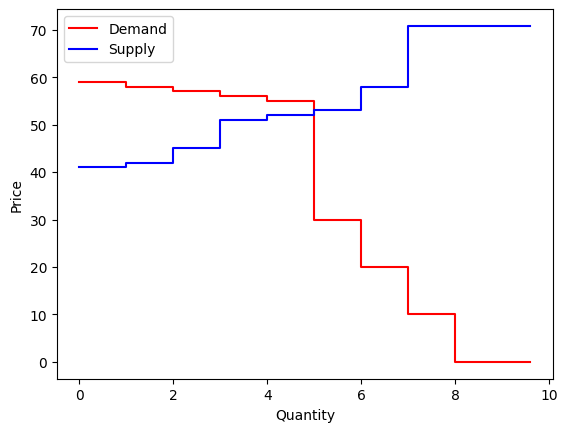

In [ ]:
bm.plot()